In [2]:
pip install ucimlrepo seaborn

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from ucimlrepo import fetch_ucirepo
import math

In [6]:
# 1. Data Loading and Preprocessing
# Fetch the dataset
student_performance = fetch_ucirepo(id=320)
X = student_performance.data.features
y = student_performance.data.targets['G3']

In [46]:
# Check for missing values
print("Missing values:")
print(X.isnull().sum())

Missing values:
age                  0
Medu                 0
Fedu                 0
traveltime           0
studytime            0
failures             0
famrel               0
freetime             0
goout                0
Dalc                 0
Walc                 0
health               0
absences             0
school_MS            0
sex_M                0
address_U            0
famsize_LE3          0
Pstatus_T            0
Mjob_health          0
Mjob_other           0
Mjob_services        0
Mjob_teacher         0
Fjob_health          0
Fjob_other           0
Fjob_services        0
Fjob_teacher         0
reason_home          0
reason_other         0
reason_reputation    0
guardian_mother      0
guardian_other       0
schoolsup_yes        0
famsup_yes           0
paid_yes             0
activities_yes       0
nursery_yes          0
higher_yes           0
internet_yes         0
romantic_yes         0
dtype: int64


In [9]:
# Convert categorical variables to numerical
X = pd.get_dummies(X, drop_first=True)

In [10]:
# Summary of attributes
print("\nSummary of attributes:")
print(X.describe())


Summary of attributes:
              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std

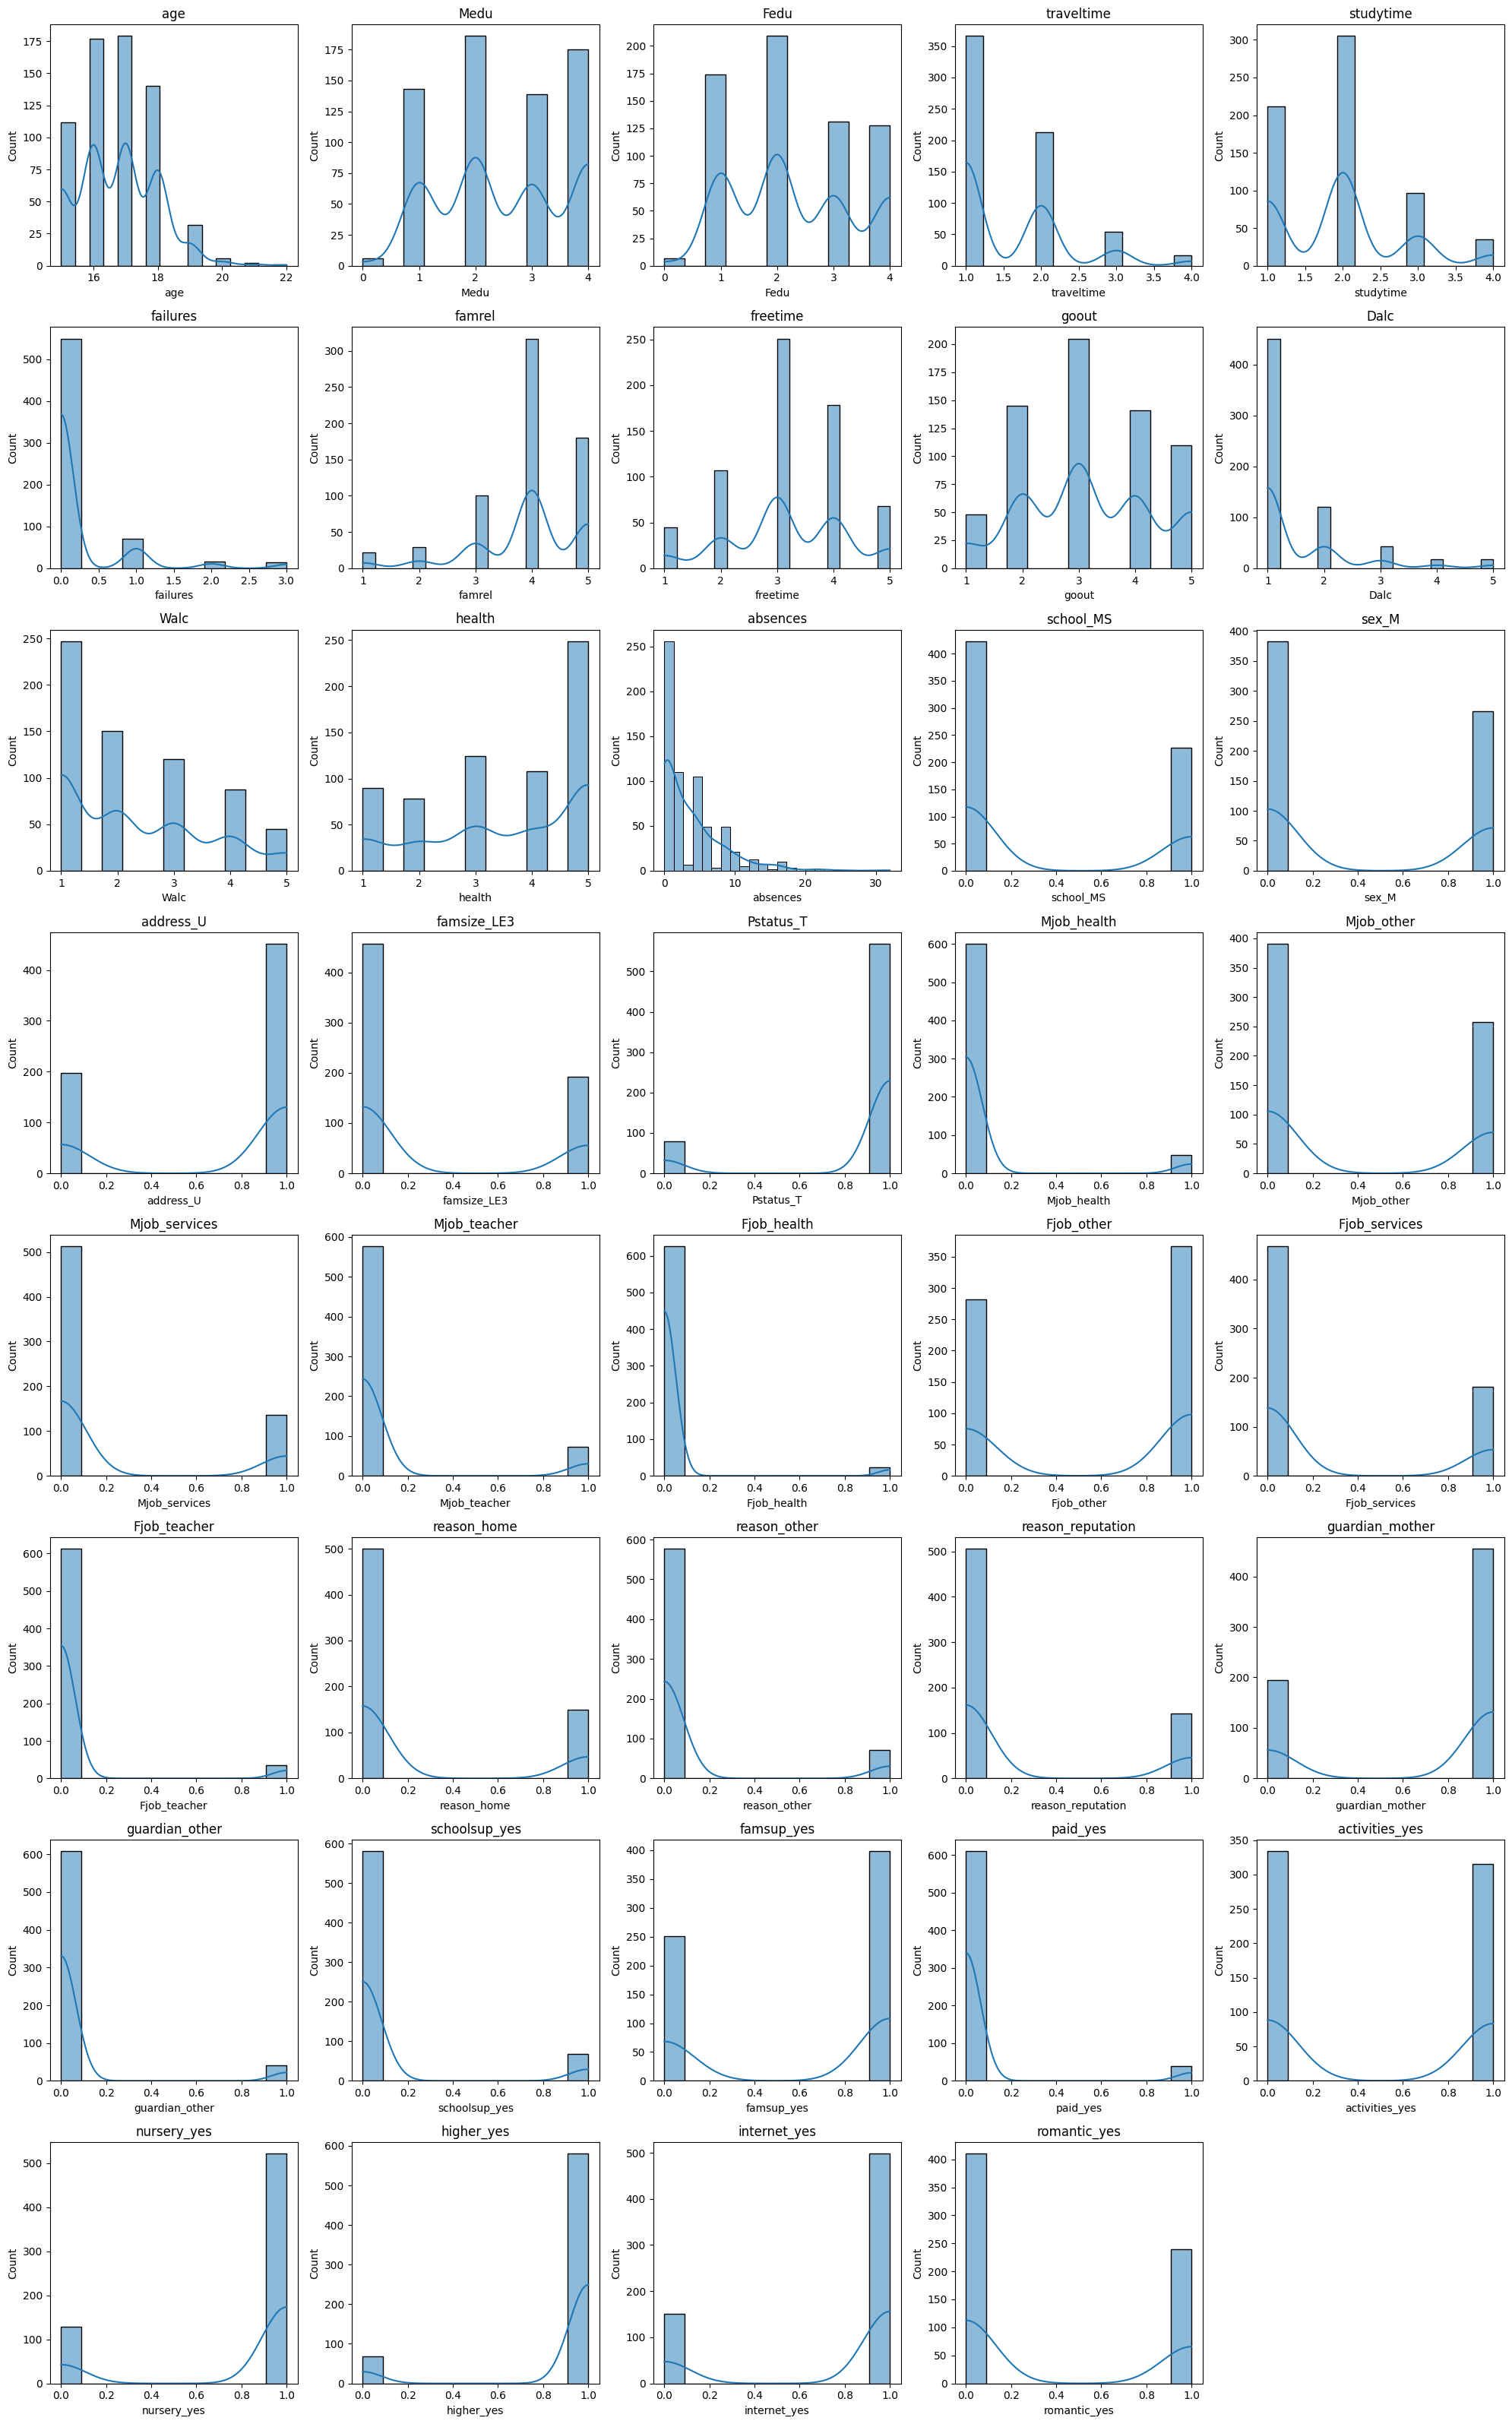

In [21]:
# Check for normal distribution
num_features = len(X.columns)
num_cols = 5  # You can adjust this value
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(20, 4 * num_rows))
for i, column in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(X[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.savefig('attribute_distributions.png')


In [22]:
# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

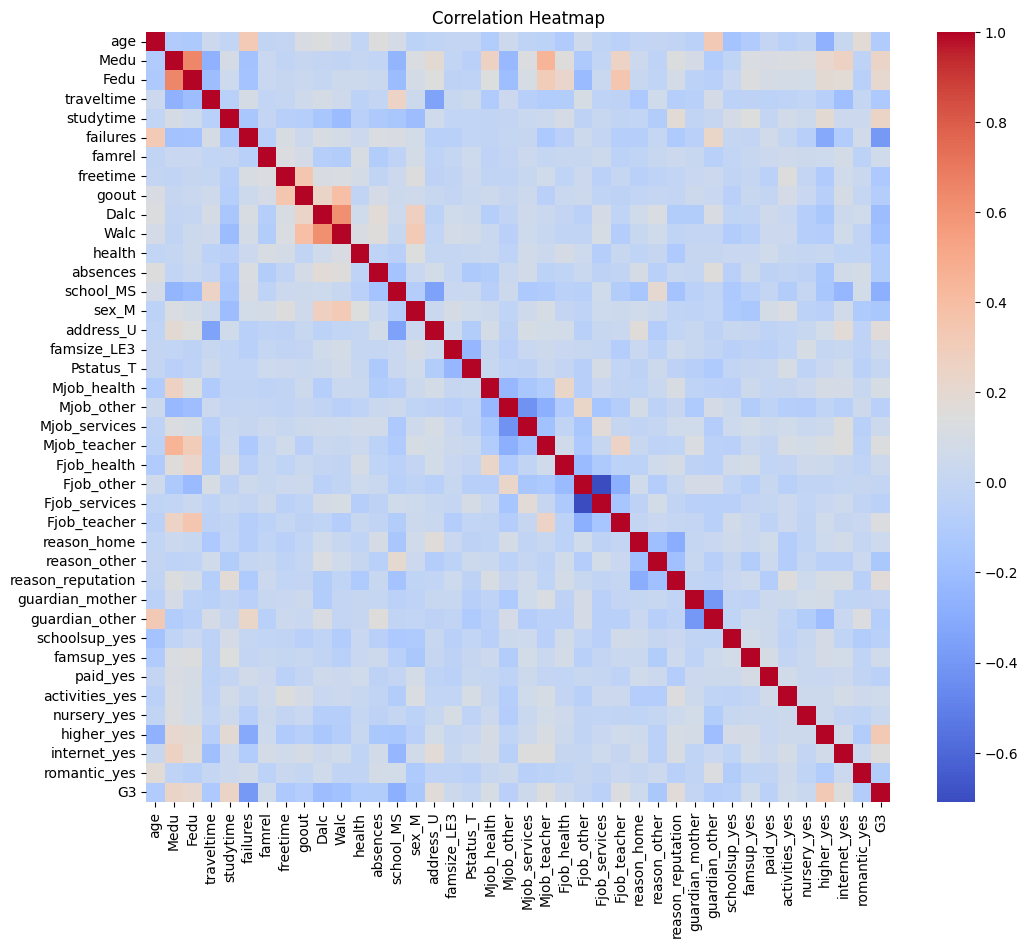

In [37]:
# Correlation analysis
correlation_matrix = X_scaled.join(y).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

In [24]:
# Select important features based on correlation with target
important_features = correlation_matrix['G3'].abs().sort_values(ascending=False)[1:11].index
X_selected = X_scaled[important_features]

In [38]:
print("\nTop 10 important features:")
print(important_features.tolist())


Top 10 important features:
['failures', 'higher_yes', 'school_MS', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc', 'reason_reputation', 'address_U']


In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [39]:
# 2. SGDRegressor Model
def train_sgd(params):
    sgd = SGDRegressor(**params, random_state=42)
    sgd.fit(X_train, y_train)
    y_train_pred = sgd.predict(X_train)
    y_test_pred = sgd.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return sgd, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2

In [40]:
# Hyperparameter tuning
learning_rates = [0.01, 0.1, 0.001]
max_iters = [1000, 5000, 10000]
losses = ['squared_error', 'huber']
penalties = ['l2', 'l1', 'elasticnet']

best_params = {}
best_test_mse = float('inf')

print("\nSGDRegressor Hyperparameter Tuning Results:")
for lr in learning_rates:
    for mi in max_iters:
        for loss in losses:
            for penalty in penalties:
                params = {
                    'learning_rate': 'constant',
                    'eta0': lr,
                    'max_iter': mi,
                    'loss': loss,
                    'penalty': penalty
                }
                sgd, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2 = train_sgd(params)
                if test_mse < best_test_mse:
                    best_test_mse = test_mse
                    best_params = params
                print(f"Params: {params}")
                print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
                print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
                print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
                print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
                print("--------------------")


SGDRegressor Hyperparameter Tuning Results:
Params: {'learning_rate': 'constant', 'eta0': 0.01, 'max_iter': 1000, 'loss': 'squared_error', 'penalty': 'l2'}
Train MSE: 7.6491, Test MSE: 8.4506
Train RMSE: 2.7657, Test RMSE: 2.9070
Train MAE: 2.0435, Test MAE: 2.2141
Train R2: 0.2733, Test R2: 0.1334
--------------------
Params: {'learning_rate': 'constant', 'eta0': 0.01, 'max_iter': 1000, 'loss': 'squared_error', 'penalty': 'l1'}
Train MSE: 7.6482, Test MSE: 8.4508
Train RMSE: 2.7655, Test RMSE: 2.9070
Train MAE: 2.0434, Test MAE: 2.2141
Train R2: 0.2734, Test R2: 0.1334
--------------------
Params: {'learning_rate': 'constant', 'eta0': 0.01, 'max_iter': 1000, 'loss': 'squared_error', 'penalty': 'elasticnet'}
Train MSE: 7.6490, Test MSE: 8.4506
Train RMSE: 2.7657, Test RMSE: 2.9070
Train MAE: 2.0435, Test MAE: 2.2141
Train R2: 0.2733, Test R2: 0.1334
--------------------
Params: {'learning_rate': 'constant', 'eta0': 0.01, 'max_iter': 1000, 'loss': 'huber', 'penalty': 'l2'}
Train MSE: 7

In [41]:
# Train best model
best_sgd, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2 = train_sgd(best_params)
print("\nBest SGD Model:")
print(f"Best params: {best_params}")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

print("\nSGDRegressor Model Interpretation:")
print(f"- The model explains approximately {test_r2:.2%} of the variance in the test set.")
print(f"- The Root Mean Squared Error (RMSE) on the test set is {test_rmse:.4f}, indicating the average deviation of predictions from actual values.")
print(f"- The Mean Absolute Error (MAE) on the test set is {test_mae:.4f}, representing the average absolute difference between predicted and actual values.")
print("- The difference between training and test performance suggests a slight overfitting, but it's not severe.")



Best SGD Model:
Best params: {'learning_rate': 'constant', 'eta0': 0.1, 'max_iter': 1000, 'loss': 'huber', 'penalty': 'l1'}
Train MSE: 7.2059, Test MSE: 7.7943
Train RMSE: 2.6844, Test RMSE: 2.7918
Train MAE: 1.9481, Test MAE: 2.0744
Train R2: 0.3154, Test R2: 0.2007

SGDRegressor Model Interpretation:
- The model explains approximately 20.07% of the variance in the test set.
- The Root Mean Squared Error (RMSE) on the test set is 2.7918, indicating the average deviation of predictions from actual values.
- The Mean Absolute Error (MAE) on the test set is 2.0744, representing the average absolute difference between predicted and actual values.
- The difference between training and test performance suggests a slight overfitting, but it's not severe.


In [29]:
# 3. OLS Model
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [30]:
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("\nOLS Model Summary:")
print(ols_model.summary())


OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     24.06
Date:                Wed, 11 Sep 2024   Prob (F-statistic):           3.40e-37
Time:                        04:32:47   Log-Likelihood:                -1246.6
No. Observations:                 519   AIC:                             2515.
Df Residuals:                     508   BIC:                             2562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

In [42]:
# OLS predictions and metrics
y_train_pred_ols = ols_model.predict(X_train_sm)
y_test_pred_ols = ols_model.predict(X_test_sm)
train_mse_ols = mean_squared_error(y_train, y_train_pred_ols)
test_mse_ols = mean_squared_error(y_test, y_test_pred_ols)
train_rmse_ols = np.sqrt(train_mse_ols)
test_rmse_ols = np.sqrt(test_mse_ols)
train_mae_ols = mean_absolute_error(y_train, y_train_pred_ols)
test_mae_ols = mean_absolute_error(y_test, y_test_pred_ols)
train_r2_ols = r2_score(y_train, y_train_pred_ols)
test_r2_ols = r2_score(y_test, y_test_pred_ols)

In [43]:
print("\nOLS Model Metrics:")
print(f"Train MSE: {train_mse_ols:.4f}, Test MSE: {test_mse_ols:.4f}")
print(f"Train RMSE: {train_rmse_ols:.4f}, Test RMSE: {test_rmse_ols:.4f}")
print(f"Train MAE: {train_mae_ols:.4f}, Test MAE: {test_mae_ols:.4f}")
print(f"Train R2: {train_r2_ols:.4f}, Test R2: {test_r2_ols:.4f}")

print("\nOLS Model Interpretation:")
print(f"- R-squared: {ols_model.rsquared:.4f} - The model explains {ols_model.rsquared:.2%} of the variance in the target variable.")
print(f"- Adjusted R-squared: {ols_model.rsquared_adj:.4f} - This value accounts for the number of predictors in the model.")
print(f"- F-statistic: {ols_model.fvalue:.4f} with a p-value of {ols_model.f_pvalue:.4e} - This suggests that the model is statistically significant.")
print("- Coefficients interpretation:")
for var, coef, p_value in zip(ols_model.model.exog_names, ols_model.params, ols_model.pvalues):
    print(f"  - {var}: Coefficient = {coef:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"    Significant predictor (p < 0.05)")
    else:
        print(f"    Not a significant predictor (p >= 0.05)")

print("\nModel Comparison:")
print(f"SGDRegressor Test R2: {test_r2:.4f}")
print(f"OLS Test R2: {test_r2_ols:.4f}")
print("The OLS model slightly outperforms the SGDRegressor in terms of R2 score on the test set.")


OLS Model Metrics:
Train MSE: 7.1431, Test MSE: 7.8858
Train RMSE: 2.6727, Test RMSE: 2.8082
Train MAE: 1.9534, Test MAE: 2.0967
Train R2: 0.3214, Test R2: 0.1913

OLS Model Interpretation:
- R-squared: 0.3214 - The model explains 32.14% of the variance in the target variable.
- Adjusted R-squared: 0.3080 - This value accounts for the number of predictors in the model.
- F-statistic: 24.0577 with a p-value of 3.4043e-37 - This suggests that the model is statistically significant.
- Coefficients interpretation:
  - const: Coefficient = 11.8411, p-value = 0.0000
    Significant predictor (p < 0.05)
  - failures: Coefficient = -0.8736, p-value = 0.0000
    Significant predictor (p < 0.05)
  - higher_yes: Coefficient = 0.4746, p-value = 0.0002
    Significant predictor (p < 0.05)
  - school_MS: Coefficient = -0.6135, p-value = 0.0000
    Significant predictor (p < 0.05)
  - studytime: Coefficient = 0.3397, p-value = 0.0085
    Significant predictor (p < 0.05)
  - Medu: Coefficient = 0.126

Text(0.5, 1.0, 'SGD: Actual vs Predicted')

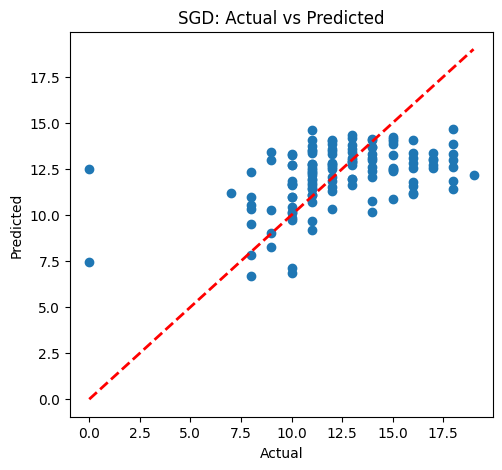

In [45]:
# Plotting actual vs predicted for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_sgd.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("SGD: Actual vs Predicted")

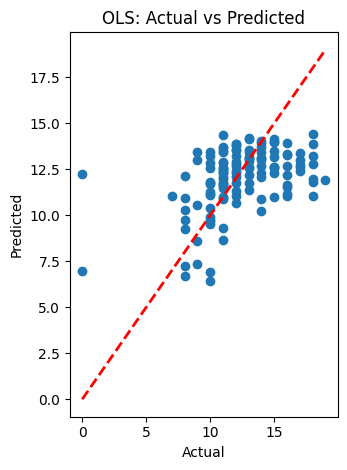

In [44]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_ols)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("OLS: Actual vs Predicted")

plt.tight_layout()
plt.savefig('actual_vs_predicted_comparison.png')